In [ ]:
#| default_exp wrapping

## Shrink-wrapping

> Morph one surface mesh onto another by projecting each vertex to closest point on target surface. Part of pipeline for dynamic data.

This notebook builds the tools for automated mesh "shrink-wrapping" (setting vertex positions of one mesh to the closest point on another mesh). This is a part of the pipeline for dynamic surfaces discussed in tutorial 8. Shrink-wrapping can also be done interactively in blender, using the shrink-wrap modifier.

In [ ]:
#| export

from blender_tissue_cartography import io as tcio
from blender_tissue_cartography import mesh as tcmesh
from blender_tissue_cartography import registration as tcreg
from blender_tissue_cartography import smoothing as tcsmooth

import numpy as np
from copy import deepcopy
import warnings
import igl

from scipy import sparse

In [ ]:
#| hide

from blender_tissue_cartography import interpolation as tcinterp
from skimage import transform
from scipy import stats, spatial, linalg
import os
import matplotlib.pyplot as plt

In [ ]:
from tqdm.notebook import tqdm

## Loading and segmenting the dataset

We will use the same dataset - a _Drosophila_ example - as in tutorial 4.

In [ ]:
metadata_dict = {'filename': 'datasets/wrapping_example/Drosophila_CAAX-mCherry',
                 'resolution_in_microns': (1.05, 1.05, 1.05), # lightsheet data has isotropic resolution
                 'subsampling_factors': (1/2, 1/2, 1/2),
                }

In [ ]:
image = tcio.adjust_axis_order(tcio.imread(f"{metadata_dict['filename']}.tif"))
print("image shape:", image.shape) # image shape - spatial axes are in z-x-y order

image shape: (1, 190, 509, 188)


### 3d segmentation / Meshing

Already done - we'll just read in the results.

### Registration

Using the tools from notebook 4a, compute an affine registration of the reference to the data mesh.

In [ ]:
mesh_data = tcmesh.ObjMesh.read_obj(f"{metadata_dict['filename']}_mesh_remeshed.obj")
mesh_ref = tcmesh.ObjMesh.read_obj(f"datasets/wrapping_example/Drosophila_reference.obj")

  o embryo_rect


In [ ]:
trafo_centroid_intertia, _ = tcreg.align_by_centroid_and_intertia(mesh_ref.vertices, mesh_data.vertices,
                                                                  q=0.01, shear=True)

trafo_icp, _, _ = tcreg.icp(mesh_ref.vertices, mesh_data.vertices, initial=trafo_centroid_intertia,
                            threshold=1e-4, max_iterations=100, include_scaling=True, n_samples=5000)

In [ ]:
# We now save the pre-registered mesh. Note that we want to transform both our
# mesh coordinates and the corresponding normals, as well as potentially flip face orientation

mesh_registered = mesh_ref.apply_affine_to_mesh(trafo_icp)
mesh_registered.name = "Drosophila_reference_preregistered"
mesh_registered.write_obj(f"datasets/wrapping_example/Drosophila_reference_registered.obj")

### Shrink-wrapping using `libigl`

In [ ]:
# Load source and target mesh
mesh_target = tcmesh.ObjMesh.read_obj("datasets/wrapping_example/Drosophila_CAAX-mCherry_mesh_remeshed.obj")
mesh_source = tcmesh.ObjMesh.read_obj("datasets/wrapping_example/Drosophila_reference_registered.obj")

  o Drosophila_reference_preregistered


In [ ]:
# compute closest point on target mesh for each source vertex
distances, indices, points = igl.point_mesh_squared_distance(mesh_source.vertices,
                                                             mesh_target.vertices, mesh_target.tris)

In [ ]:
# points are closest points on the surface, not necessarily vertices
np.linalg.norm(points[10]-mesh_target.vertices, axis=1).min()

1.927821820512808

In [ ]:
# indices are triangle indices
indices.max(), mesh_target.vertices.shape[0]

(16845, 8425)

In [ ]:
mesh_wrapped = tcmesh.ObjMesh(points, mesh_source.faces, texture_vertices=mesh_source.texture_vertices,
                            normals=None, name=mesh_source.name)
mesh_wrapped.set_normals()

In [ ]:
mesh_wrapped.write_obj("datasets/wrapping_example/Drosophila_reference_wrapped_igl.obj")

In [ ]:
#| export

def shrinkwrap_igl(mesh_source, mesh_target, n_iter_smooth_target=10, n_iter_smooth_wrapped=10):
    """
    Shrink-wrap the source mesh onto the target mesh using trimesh.
    
    Sets the vertex positions of mesh_source to the closest point on the surface of mesh_target (not necessarily
    a vertex). Optionally, smooth the target mesh and the wrapped mesh for smoother results using a Taubin
    filter (recommended). Gives out a warning if the shrink-wrapping flips any vertex normals, which can
    indicate problems.
    
    The shrinkwrapped mesh still has the UV maps of the source mesh, and so can be used to compute
    cartographic projections. Assumes mesh is triangular.
    
    Parameters
    ----------
    mesh_source : tcmesh.ObjMesh
        Mesh to be deformed
    mesh_target : tcmesh.ObjMesh
        Mesh with the target shape
    n_iter_smooth_target : int, default 10
        Taubin smoothing iterations for target
    n_iter_smooth_wrapped : int, default 10
        Taubin smoothing iterations for shrinkwrapped mesh, after shrinkwrapping

    Returns
    -------
    mesh_wrapped : tcmesh.ObjMesh

    """
    if not mesh_target.is_triangular:
        warnings.warn(f"Warning: mesh not triangular - result may be incorrect", RuntimeWarning)
    # smooth if necessary
    if n_iter_smooth_target > 0:
        target_verts = tcsmooth.smooth_taubin(mesh_target, n_iter=n_iter_smooth_target).vertices
    else:
        target_verts = mesh_target.vertices
    # compute closest point on target mesh for each source vertex
    distances, indices, points = igl.point_mesh_squared_distance(mesh_source.vertices,
                                                                 target_verts, mesh_target.tris)
    # create wrapped mesh
    mesh_wrapped = tcmesh.ObjMesh(points, mesh_source.faces, texture_vertices=mesh_source.texture_vertices,
                                normals=None, name=mesh_source.name)
    mesh_wrapped.set_normals()
    if n_iter_smooth_wrapped > 0:
        mesh_wrapped = tcsmooth.smooth_taubin(mesh_wrapped, n_iter=n_iter_smooth_wrapped)
    # check if any normals were flipped
    dots = np.einsum("vi,vi->v", mesh_source.normals, mesh_wrapped.normals)
    if np.sum(dots < 0) > 0:
        warnings.warn(f"Warning: {np.sum(dots<0)} normal(s) flipped during shrink-wrapping", RuntimeWarning)
    return mesh_wrapped

In [ ]:
%%time
mesh_wrapped = shrinkwrap_igl(mesh_source, mesh_target)
mesh_wrapped.write_obj("datasets/wrapping_example/Drosophila_reference_wrapped_igl.obj")

CPU times: user 2.09 s, sys: 51.9 ms, total: 2.14 s
Wall time: 2.04 s


### Attribute copying

We can use the shrink-wrap technique to copy over per-vertex attributes from one mesh to another. This is nothing other than barycentric interpolation, and we can use `interpolation.interpolate_barycentric`!

## UV projection

To see how well all of this has worked, let's use the wrapped mesh to generate UV projections.

In [ ]:
normal_offsets = np.array([-4, -2, 0, 2]) ##np.linspace(-5, 2, 8) # in microns
metadata_dict["normal_offsets"] = normal_offsets # add the info to the metadata
uv_grid_steps = 512

In [ ]:
tcio.save_dict_to_json(f"{metadata_dict['filename']}_metadata.json", metadata_dict)

In [ ]:
projected_data_wrapped, projected_coordinates_wrapped, projected_normals_wrapped = tcinterp.create_cartographic_projections(
    image=f"{metadata_dict['filename']}.tif",
    mesh=f"datasets/wrapping_example/Drosophila_reference_wrapped_igl.obj",
    resolution=metadata_dict["resolution_in_microns"],
    normal_offsets=normal_offsets,
    uv_grid_steps=uv_grid_steps,
    use_fallback=False) # don't worry about warning - it just looks like the reference mesh has a UV map with 'flipped' orientation.

/home/nikolas/Documents/UCSB/streichan/numerics/code/python code/jupyter notebooks/blender-tissue-cartography/blender_tissue_cartography/interpolation.py:215: RuntimeWarning: UV map has self-intersections, 111104 flipped triangles. Try use_fallback=True?
  warnings.warn("UV map has self-intersections, {} flipped triangles. Try use_fallback=True?".format(


<matplotlib.image.AxesImage>

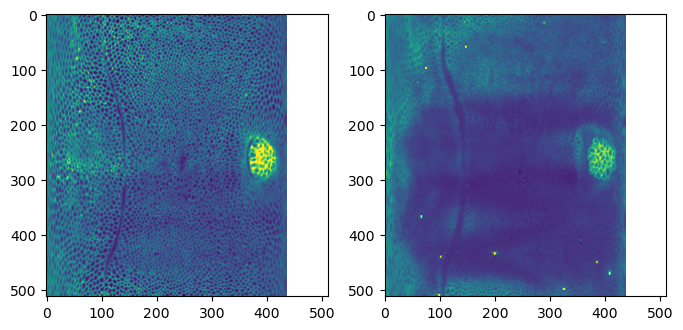

In [ ]:
# show the projected data - looks good!

fig, (ax1, ax2) = plt.subplots(figsize=(8,8), ncols=2)
ax1.imshow(projected_data_wrapped[0, 0], vmax=10000)
ax2.imshow(projected_data_wrapped[0, 2], vmax=10000)